#### File Setup

In [447]:
#pip install pycountry-convert --quiet
#pip install seaborn  --quiet
#pip install scipy --quiet
#pip install researchpy --quiet
#pip install statsmodels --quiet

In [484]:
import pandas as pd 
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
import statsmodels.api as sm

In [485]:
####csv_file = "/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/data/072823_results.csv"
csv_file = "/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/data/080823_results.csv"

###
###csv_file = "/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/data/080523_results.csv"

df = pd.read_csv(csv_file)
print(df.shape)

(351, 94)


In [486]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 94 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   StartDate                      351 non-null    object 
 1   EndDate                        351 non-null    object 
 2   Status                         351 non-null    object 
 3   Progress                       351 non-null    int64  
 4   Duration (in seconds)          351 non-null    int64  
 5   Finished                       351 non-null    bool   
 6   RecordedDate                   351 non-null    object 
 7   ResponseId                     351 non-null    object 
 8   DistributionChannel            351 non-null    object 
 9   UserLanguage                   351 non-null    object 
 10  Q_RecaptchaScore               324 non-null    float64
 11  Q1. Metadata_Browser           351 non-null    object 
 12  Q1. Metadata_Version           351 non-null    obj

#### Basic Data Cleaning 

In [487]:
##### Data cleaning to change column types

#drop anyone not sorted into condition 
df_clean = df.drop(df[df['Condition'].isna()].index)

#change data type to int 
df_clean['Condition'] =  df_clean['Condition'].astype('int64')

# create frame column gain or loss condition based on condition value 
df_clean['frame'] = df_clean['Condition'].apply(lambda x: 'gain' if x < 3 else 'loss')

#filter only where progress = 100 
df_clean = df_clean[df_clean['Progress']==100]
print(df_clean.shape)

(263, 95)


##### Survey Time / Completion

In [488]:
df_clean['Duration (in seconds)'].describe()

count       263.000000
mean       2280.391635
std       18053.102777
min          43.000000
25%         190.000000
50%         302.000000
75%         659.000000
max      241785.000000
Name: Duration (in seconds), dtype: float64

In [452]:
## visual completion times 
#sns.histplot( y='Duration (in seconds)', data =df_clean)
#plt.show()

In [491]:

##def remove_outliers(df, column_name):
    # Calculate Z-scores for the column
    #z_scores = stats.zscore(df[column_name])
    #threshold = 3 #3 standard deviations 
    # Filter the dataframe to keep only the data within the threshold
    ##df_clean = df[abs(z_scores) < threshold]

    #return df_clean
#apply function to remove outliers 
##column_name = 'Duration (in seconds)'
##df_clean = remove_outliers(df_clean, column_name) 


# quarterlie range
quartiles = df_clean['Duration (in seconds)'].quantile([0.25, 0.75])
iqr = quartiles[0.75] - quartiles[0.25]
lower_bound = quartiles[0.25] - 1.5 * iqr
upper_bound = quartiles[0.75] + 1.5 * iqr

#remove outlier
df_clean = df_clean[(df_clean['Duration (in seconds)'] >= lower_bound) & (df_clean['Duration (in seconds)'] <= upper_bound)]
df_clean.shape

(217, 95)

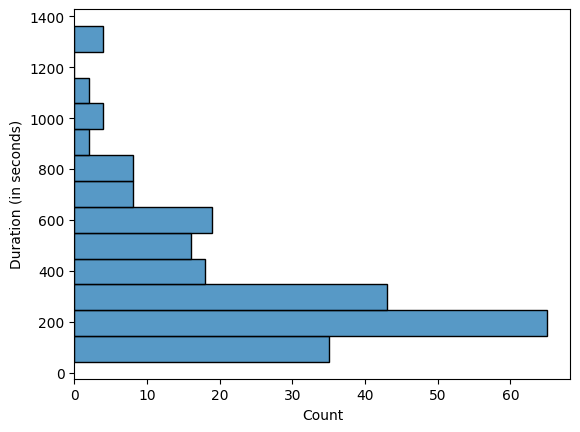

In [490]:
df_clean['Duration (in seconds)'].describe()
sns.histplot( y='Duration (in seconds)', data =df_clean)
plt.show()

In [275]:
#check for NAs
print(df.isna().sum())

StartDate                  0
EndDate                    0
Status                     0
Progress                   0
Duration (in seconds)      0
                        ... 
Q62_2_TEXT               322
Q63                       84
Q63_2_TEXT               322
Q61                      190
Condition                 41
Length: 97, dtype: int64


##### Mapping Columns & Cleaning

In [492]:
import re 
#### Creating columns and grouping for various scenarios:

#filter to option columns only
columns = df_clean.columns 
option_columns = [col for col in columns if 'Option' in col]

# dictionary mapping
scenario_dict = {"GS1":"animals_gain", "GS2":"forest_gain", "GS3":"humans_gain", "LS1":"animals_loss", "LS2":"forest_loss", "LS3":"humans_loss"  }

#set columns based on scenario 
def scenario(row):
    for col in option_columns:
        if pd.notnull(row[col]):
            match = re.search(r'(GS\d+|LS\d+)', col)
            if match:
                return match.group()
    return None

# get scenario from dictionary 
def get_scenario(row):
    value = row['scenario']
    if value in scenario_dict:
        return scenario_dict[value]
    return None

# match scenario to dict
df_clean['scenario'] = df_clean[option_columns].apply(lambda row: scenario(row), axis=1)
df_clean['scenario_mapped'] = df_clean.apply(lambda row: get_scenario(row), axis=1)


In [493]:
##### Option Column Cleaning
# select option columns 
df_clean['option_selected'] = df_clean[option_columns].fillna(method='ffill', axis=1).iloc[:, -1]
##option_columns = ['Q12. GS1, Option','Q12. GS2, Option', 'Q12. GS3, Option.', 'Q12. LS1, Option', 'Q12. LS2, Option', 'Q12. LS3, Option']

# Rating column clean & creation 
rating_columns = ['Q13. GS1, Rating','Q13. GS2, Rating', 'Q13. GS3, Rating', 'Q13. LS1, Rating', 'Q13. LS2, Rating', 'Q13. LS3, Rating']
#create a new rating column containing the non-null values of the rating columns 
df_clean['rating'] = df_clean[rating_columns].fillna(method='ffill', axis=1).iloc[:, -1]
# drop where rating is na 
df_clean = df_clean[df_clean['rating'].notna()]
# get the number only from the column 
df_clean['rating_num'] = df_clean['rating'].apply(lambda x: x.split(":")[0])
# change to integer for calculation 
df_clean['rating_num'] = df_clean['rating_num'].astype('int')

# Rationale column cleaning
rationale_columns = ['Q13. GS1, Rationale','Q14. GS2, Rationale', 'Q14. GS3, Rationle', 'Q14. LS1, Rationale', 'Q14. LS2, Rationale', 'Q14. LS3, Rationale']
# create a new rationale column containing the non-null values of the rating columns 
df_clean['rationale'] = df_clean[rationale_columns].fillna(method='ffill', axis=1).iloc[:, -1]

### Drop standalone choice, rationale, and rating columns
colu = rationale_columns + option_columns + rating_columns
df_clean = df_clean.drop(colu, axis= 'columns')
df_clean.shape

(216, 83)

In [494]:
### Cleaning and dropping time columns ###
columns = list(df_clean.columns)

###  First click columns
time_click1 = [col for col in columns if 'first click' in col.lower()]
#time first click for the scenario 
time_click1_scn = [string for string in time_click1 if string.startswith('Q10')]
#make as 1 column 
df_clean['scn_t_first_click'] = df_clean[time_click1_scn].fillna(method='ffill', axis=1).iloc[:, -1]

### Last click columns
time_click2 = [col for col in columns if 'last click' in col.lower()]
time_click2_scn = [string for string in time_click2 if string.startswith('Q10')]
df_clean['scn_t_last_click'] = df_clean[time_click2_scn].fillna(method='ffill', axis=1).iloc[:, -1]

### Time Submit Scenario columns
time_submit = [col for col in columns if 'submit' in col.lower()]
time_submit_scn = [string for string in time_submit if string.startswith('Q10')]
df_clean['scn_t_submit'] = df_clean[time_submit_scn].fillna(method='ffill', axis=1).iloc[:, -1]

#click_count1_scn = [string for string in click_count1 if 'dem' in string.lower()]

## drop Q10 time columns 
columns_drop = time_click2_scn + time_click1_scn + time_submit_scn
df_clean = df_clean.drop(columns_drop, axis = 'columns')

##Click count cleaning 
columns = list(df_clean.columns)
## Click Count for Scenario 
click_count1 = [col for col in columns if 'click count' in col.lower()]
#filer only scenario click coun t
click_count_scn = [string for string in click_count1 if string.startswith('Q10')]
#make as 1 column for all scenarios 
df_clean['scn_click_count'] = df_clean[click_count_scn].fillna(method='ffill', axis=1).iloc[:, -1]

## Click Count for Scenario 
click_count = [col for col in columns if 'click count' in col.lower()]
click_count1_dem = [string for string in click_count if 'dem' in string.lower()]
df_clean['dem_click_count'] = df_clean[click_count1_dem].fillna(method='ffill', axis=1).iloc[:, -1]

# drop scenario and dem click count columns 
columns_drop = click_count_scn + click_count1_dem
df_clean = df_clean.drop(columns_drop, axis = 'columns')

### drop metadata or misc columns from analysis 
metadata_or_misc = ['Q1. Metadata_Browser','Q1. Metadata_Version', 'Q1. Metadata_Operating System','Q1. Metadata_Resolution', 'UserLanguage', 'DistributionChannel', 'Status']
df_clean = df_clean.drop(metadata_or_misc, axis = 'columns')

In [495]:
scenario_times = ['scn_t_first_click',  'scn_t_last_click', 'scn_t_submit']
df_clean[scenario_times]
#create column for total time for scenario question: 
df_clean['scenario_time_to_choose'] = df_clean['scn_t_last_click'] - df_clean['scn_t_first_click']
df_clean['scenario_total_time'] = df_clean['scn_t_submit'] - df_clean['scn_t_first_click']
scenario_time = ['scenario_time_to_choose', 'scenario_total_time']
df_clean[scenario_time].describe()

,scenario_time_to_choose,scenario_total_time
count,216.000000,216.000000
mean,70.598880,83.510565
std,85.901246,88.489586
min,0.489000,1.678000
25%,14.935000,26.992000
50%,43.203000,60.025000
75%,98.494250,110.527500
max,650.846000,652.779000


In [496]:
df_clean.shape

(216, 57)

### Demographics

##### Cleaning 

In [506]:
#rename columns 
df_clean = df_clean.rename(columns={
    'Q5. Age': 'age',
    'Q6. Gender': 'gender',
    'Q6. Gender_4_TEXT': 'gender_text',
    'Q8. Ethnicity': 'ethnicity',
    'Q8. Ethnicity_6_TEXT': 'ethnicity_text',
    'Q9. Education': 'education',
    'Q10. Country': 'country',
    'Q10. Student': 'student',
    'Q91': 'ADP_familiar'
})

In [507]:
###coutry name clean 
import pycountry_convert as pc

#function to rename messy countries
def rename_countries(country):
    if pd.isnull(country):  # Check if the value is nan
        return country
    if country in ['United States of America', 'USA', 'US', 'us', 'usa', 'America', 'America   ', 'the United States', 'The United States',  'United States ', 'Amrican', 'United States', 'Florida', 'New York', 'MA', 'NZ', 'North Carolina', 'Newyork', 'denver']:
        return 'USA'
    elif country in ['United Kingdom', 'United Kingdom ', 'UK', 'England', 'England ', 'Cambridge', 'London', 'uuk', 'the Netherlands']:
        return 'UK'
    elif country in ['China', '中国', 'Chinese ', '美国','加州']:
        return 'China'
    elif country in [ 'New Zealand']:
        return 'New Zealand'
    elif country in ['Paris, France', 'France']:
        return 'France'
    elif country in ['Australia', 'Australia ']:
        return 'Australia'
    elif country in ['pakistan']:
        return 'Pakistan'
    else:
        return country  # return the original name if no match is found

#update country column 
df_clean['country'] = df_clean['country'].apply(rename_countries)
#strip any remaining whitespaces
df_clean['country'] = df_clean['country'].apply(lambda x: x.strip() if isinstance(x, str) else x) #checks if string, then removes spaces 

# Map each country to the continent
def country_to_continent(country_name):
    try:
        if country_name == 'USA':
            country_alpha2 = "US"
        elif country_name == 'UK':
            country_alpha2 = "GB"
        else:
            country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except:
        return "Unknown"

df_clean['continent'] = df_clean['country'].apply(country_to_continent)

In [508]:
###### Cat Code Variables #########

# ####Gender: clean gender column into numbers
#clean third cat as 'other'
df_clean['gender'] = df_clean.gender.apply(lambda x: "Female" if x == 'Female' else ("Male" if x == 'Male' else "Other"))
#0 if female, 1 if male, 2 if other 
df_clean['gender_num'] = df_clean.gender.apply(lambda x: 0 if x == 'Female' else (1 if x == 'Male' else 2))
df_clean.groupby(['gender','gender_num'])['ResponseId'].count()

####Student: clean student column into numbers
#0 if not a student, 1 if a student
df_clean['student_num']= df_clean.student.astype('category').cat.codes
df_clean.groupby(['student','student_num'])['ResponseId'].count()

####Education: clean education column into numbers
#education_num: 0 = Associates, 1 = Bachecholars, 2 = Completed High School, 3 = Grad School, 4 = Prefer Not to Say, 5 = Some high school 
df_clean['education_num']= df_clean.education.astype('category').cat.codes
df_clean.groupby(['education','education_num'])['ResponseId'].count()

#### Ethnicity: clean ethnicity column into numbers
#ethnicity: 0 = African American, 1 = Black/African/Caribbean, 2 = Prefer not to say, 3 = White or Caucasian
df_clean['ethnicity_num']= df_clean.ethnicity.astype('category').cat.codes
df_clean.groupby(['ethnicity','ethnicity_num'])['ResponseId'].count()

#### Continent: clean contintent column into numbers
#continent: 0 = Asia, 1 = Europe, 2 = North America, 3 = Oceania, 4 = South America, 5 = Unknown 
df_clean['contintent_num']= df_clean.continent.astype('category').cat.codes
df_clean.groupby(['continent','contintent_num'])['ResponseId'].count()

#### ADP: lean ADP column into numbers
#ADP: 0 = I'm not sure, 1 = No, 2 = Yes 
df_clean['ADP_num']= df_clean.ADP_familiar.astype('category').cat.codes
df_clean.groupby(['ADP_familiar','ADP_num'])['ResponseId'].count()

#### Age: clean age column into numbers
#age: {'18 - 24 years old': 0, '25 - 34 years old': 1, '35 - 44 years old': 2, '45 - 54 years old': 3, '55 - 64 years old': 4}
age_order = ['18 - 24 years old', '25 - 34 years old', '35 - 44 years old', '45 - 54 years old', '55 - 64 years old']
age_mapping = {age: i for i, age in enumerate(age_order)}
df_clean['age_num'] = df_clean['age'].map(age_mapping) #maps dict 


#### Demographic Insights 

Defintions
- gender_num: 0 = female, 1 = male, 2 = other
- student_num: 0 = not a studnet, 1 = a student, -1 = NA
- education_num: 0 = Associates, 1 = Bachecholars, 2 = Completed High School, 3 = Grad School, 4 = Prefer Not to Say, 5 = Some high school 
- ethnicity: 0 = African American, 1 = Black/African/Caribbean, 2 = Prefer not to say, 3 = White or Caucasian
- continent: 0 = Asia, 1 = Europe, 2 = North America, 3 = Oceania, 4 = South America, 5 = Unknown 
- ADP: 0 = I'm not sure, 1 = No, 2 = Yes 
- age: {'18 - 24 years old': 0, '25 - 34 years old': 1, '35 - 44 years old': 2, '45 - 54 years old': 3, '55 - 64 years old': 4}

##### Participant Demographic Insights 

In [16]:
#Participant Demographic Insights 
demographics =   [ 'ResponseId','gender_num', 'gender', 'student_num', 'student','education_num', 'education','ethnicity_num','ethnicity', 'contintent_num', 'continent','age_num', 'age', 'ADP_num', 'ADP_familiar'] 
df_demographics = df_clean[demographics]

#ethnicity
df_demographics.ethnicity.value_counts(normalize=True).to_frame()

,proportion
ethnicity,
White or Caucasian,0.702439
Asian,0.156098
Black/African/Caribbean,0.126829
Prefer not to say,0.009756
Other,0.004878


In [17]:
df_demographics['gender'].value_counts(normalize=True).to_frame()

,proportion
gender,
Male,0.500000
Female,0.461165
Other,0.038835


In [18]:
df_demographics['continent'].value_counts(normalize=True).to_frame()

,proportion
continent,
North America,0.466019
Unknown,0.223301
Europe,0.199029
Asia,0.082524
Oceania,0.014563
South America,0.014563


In [19]:
df_demographics['student'].value_counts(normalize=True).to_frame()

,proportion
student,
No,0.512195
Yes,0.487805


In [20]:
df_demographics['ADP_familiar'].value_counts(normalize=True).to_frame()

,proportion
ADP_familiar,
Yes,0.559406
No,0.326733
I'm not sure,0.113861


In [21]:
df_demographics['education'].value_counts(normalize=True).to_frame()

,proportion
education,
Bachelor's degree,0.409756
Associates or technical degree,0.229268
"Graduate or professional degree (MA, MS, MBA, PHd, JD, MD, etc.)",0.200000
Completed high school / secondary school,0.126829
Some high school / secondary school or less,0.034146


In [22]:
df_demographics.describe()

,gender_num,student_num,education_num,ethnicity_num,contintent_num,age_num,ADP_num
count,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000
mean,0.577670,0.480583,1.388350,2.956311,2.349515,1.009709,1.398058
std,0.568512,0.510487,1.153853,1.641841,1.581655,0.820412,0.763047
min,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,0.000000,1.000000,4.000000,2.000000,1.000000,2.000000
75%,1.000000,1.000000,2.000000,4.000000,2.750000,1.000000,2.000000
max,2.000000,1.000000,4.000000,4.000000,5.000000,4.000000,2.000000


In [80]:
#gen_cross_tab = pd.crosstab(df_clean['gender'], df_clean['frame'])
#gen_cross_tab

frame,gain,loss
gender,,
Female,42,53
Male,52,51
Non-binary / third gender,2,1
Prefer not to say,1,0
Prefer to self-describe,3,0


In [81]:
#df_clean.groupby(['age', 'age_num'])['ResponseId'].count()

age                age_num
18 - 24 years old  0           51
25 - 34 years old  1          115
35 - 44 years old  2           31
45 - 54 years old  3            5
55 - 64 years old  4            4
Name: ResponseId, dtype: int64

In [23]:
#summary insights 
df_clean.groupby(['frame','scenario','scenario_mapped','option_selected']).ResponseId.count()

#% in each condition (gain or loss)
df_clean['frame'].value_counts()


frame
loss    105
gain    101
Name: count, dtype: int64

##### Demographics for Experitment 2

In [483]:
df_clean = df_clean[~df_clean.scenario_mapped.isna()]

key_demographics =   [  'gender', 'student', 'education','ethnicity', 'continent', 'age', 'ADP_familiar', 'frame', 'scenario_mapped'] 
participant_demographics = df_clean[key_demographics]
#save as a csv
participant_demographics.to_csv('participant_demographics.csv', index=False)




### NEP Scoring

In [509]:
columns = df_clean.columns
#nep columns only
nep_columns = [col for col in columns if col.startswith('Q. NEP')]

#function to clean likert score data 
def extract_score(likert): 
   match = re.search(r'\d', likert)
   if match: 
      return int(match.group(0))
   return 0
   
# apply function to nep columns 
for col in df_clean[nep_columns]: 
   df_clean[col] = df_clean[col].astype(str)
df_clean[nep_columns] = df_clean[nep_columns].applymap(extract_score)

# function to sum score
def sum_score(row):
   if pd.notna(row).all():  #all nep questions answered
      return row.sum()
   else:
      return "N/A"

#new column that sums score
df_clean['NEP_Score'] = df_clean[nep_columns].apply(lambda row: sum_score(row), axis=1)


In [26]:
#some insights on each NEP question
stats_by_q = df_clean[nep_columns].describe().T
stats_by_q

,count,mean,std,min,25%,50%,75%,max
Q. NEP_1,206.0,2.349515,1.061143,0.0,2.0,2.0,3.0,5.0
Q. NEP_2,206.0,2.067961,0.975426,0.0,1.0,2.0,3.0,5.0
Q. NEP_3,206.0,1.970874,1.054202,0.0,1.0,2.0,3.0,5.0
Q. NEP_4,206.0,1.966019,1.065563,0.0,1.0,2.0,3.0,5.0
Q. NEP_5,206.0,1.864078,0.998033,0.0,1.0,2.0,2.0,5.0
Q. NEP_6,206.0,1.985437,1.028748,0.0,1.0,2.0,3.0,5.0
Q. NEP_7,206.0,2.135922,1.050422,0.0,1.0,2.0,3.0,5.0
Q. NEP_8,206.0,2.048544,1.094364,0.0,1.0,2.0,3.0,5.0


### Exploratory

In [538]:
###set-yp analysis 

main_analysis_columns = ['ResponseId', 'frame', 'scenario_mapped', 'option_selected', 'rating_num', 'rationale', 'age_num',  'gender_num',  'ethnicity_num', 'education_num',   'contintent_num', 'ADP_num', 'student_num','NEP_Score']
analysis_columns = ['ResponseId', 'frame', 'scenario_mapped', 'option_selected', 'rating', 'rating_num', 'rationale',
'age', 'age_num', 'gender',  'gender_num', 'ethnicity', 'ethnicity_num', 'education', 'education_num', 'continent',  'contintent_num', 
'ADP_num','ADP_familiar',  'student', 'student_num', 'NEP_Score']

#set up dataframe 
main_analysis = df_clean[main_analysis_columns]

#remove one off na option_selection
main_analysis = main_analysis[~main_analysis['scenario_mapped'].isna()] 

#gain & loss conditions 
gain_condition = main_analysis[main_analysis['frame']=='gain']
loss_condition = main_analysis[main_analysis['frame']=='loss']

#add scenario cleaned column with just animals, humans, or forest 
main_analysis['scenario_clean'] = main_analysis['scenario_mapped'].apply(lambda x: x.split("_")[0] ) 

In [539]:
##first look at breakdown 

#% of Participants Selecting Each Option 
frame_cross_pct = pd.crosstab(main_analysis['option_selected'], main_analysis['frame'], normalize='columns')
frame_cross_num = pd.crosstab(main_analysis['option_selected'], main_analysis['frame'])
print("Breakdown of Choice Selection")
print(f"""Sample Size: {main_analysis.shape[0]}""")
print(f"""Gain Sample Size: {main_analysis[main_analysis['frame'] == 'gain'].shape[0]}""")
print(f"""Loss Sample Size: {main_analysis[main_analysis['frame'] == 'loss'].shape[0]}""")
print(f"""\n\n{frame_cross_pct}""")

Breakdown of Choice Selection
Sample Size: 215
Gain Sample Size: 106
Loss Sample Size: 109


frame                gain      loss
option_selected                    
Proposal A       0.783019  0.688073
Proposal B       0.216981  0.311927


In [540]:
##ratin num 
print(pd.crosstab(main_analysis['frame'], main_analysis['option_selected'], values = main_analysis['rating_num'], aggfunc = 'mean' ))
rap_gain3 = main_analysis[main_analysis['frame'] == 'gain']
rap_loss3 = main_analysis[main_analysis['frame'] == 'loss']
gain_avg3 = rap_gain3.rating_num.mean()
loss_avg3 = rap_loss3.rating_num.mean()
print("gain avg rating:", gain_avg3)
print("loss avg rating:", loss_avg3)
print('delta:', loss_avg3 - gain_avg3)

option_selected  Proposal A  Proposal B
frame                                  
gain               2.602410    5.304348
loss               2.906667    5.441176
gain avg rating: 3.188679245283019
loss avg rating: 3.697247706422018
delta: 0.5085684611389993


#### Rationale & Rating Exploration

Creating dataframes for additional analysis 

In [541]:
##where rationale is null 
df_rationale_null = main_analysis[main_analysis['rationale'].isna()]

##where rationale is not null 
df_rationale_not_null = main_analysis[~main_analysis['rationale'].isna()]

##where demographics (country) is not null 
df_country_not_null = main_analysis[main_analysis['contintent_num'] != 5]
df_country_notna_ratingappr  =  rating_appr[~rating_appr['contintent_num'] == 5 ]

##look where rating is a mismatch 
rating_mismatch = main_analysis[((main_analysis['option_selected'] == 'Proposal A') & (main_analysis['rating_num'] > 4)) | (main_analysis['option_selected'] == 'Proposal B') & (main_analysis['rating_num'] < 4) ]

##look where rating is appr. 
rating_appr = main_analysis[((main_analysis['option_selected']=='Proposal A') & (main_analysis['rating_num']<= 4 )) | ((main_analysis['option_selected']=='Proposal B') & (main_analysis['rating_num'] >= 4 ))]

##look where rating is appr. & rationale is filled in 
rating_appr_rat = main_analysis[(main_analysis['option_selected']=='Proposal A') & (main_analysis['rating_num']<= 4 ) & (~main_analysis['rationale'].isna()) | (main_analysis['option_selected']=='Proposal B') & (main_analysis['rating_num'] >= 4) & (~main_analysis['rationale'].isna())]


#where rating is appr and no ADP
rating_appr_noADP = rating_appr[rating_appr['ADP_num'] != 2]

##outputs 

rating_mismatch_cross = pd.crosstab(rating_mismatch['frame'], rating_mismatch['option_selected'], values = rating_mismatch['rating_num'], aggfunc= 'mean' )
print("rating_mismatch_cross")
print(rating_mismatch_cross)

rating_appr_ct = pd.crosstab(rating_appr['frame'], rating_appr['option_selected'], values = rating_appr['rating_num'], aggfunc= 'mean' )
print("rating_appr_ct")
print(rating_appr_ct)

rating_appr_rat_ct = pd.crosstab(rating_appr_rat['frame'], rating_appr_rat['option_selected'], values = rating_appr_rat['rating_num'], aggfunc= 'mean' )
print(rating_appr_rat_ct)

main_analysis_ct = pd.crosstab(main_analysis['frame'], main_analysis['option_selected'], values = main_analysis['rating_num'], aggfunc= 'mean' )
print(main_analysis_ct)

rating_mismatch_cross
option_selected  Proposal A  Proposal B
frame                                  
gain               6.000000         2.0
loss               5.333333         3.0
rating_appr_ct
option_selected  Proposal A  Proposal B
frame                                  
gain               2.384615    5.619048
loss               2.444444    5.515152
option_selected  Proposal A  Proposal B
frame                                  
gain               2.352941    5.705882
loss               2.357143    5.515152
option_selected  Proposal A  Proposal B
frame                                  
gain               2.602410    5.304348
loss               2.906667    5.441176


In [518]:
###Compare rating data by segmentation 

##look where country is na 
print(pd.crosstab(na['frame'], na['option_selected'], values = na['rating_num'], aggfunc = 'mean' ))
rap_gain1 = na[na['frame'] == 'gain']
rap_loss1 = na[na['frame'] == 'loss']
gain_avg1 = rap_gain1.rating_num.mean()
loss_avg1 = rap_loss1.rating_num.mean()
print("gain avg rating:", gain_avg1)
print("loss avg rating:", loss_avg1)
print('delta:', loss_avg1 - gain_avg1)
print('/////')

##look where country is not na 
print(pd.crosstab(notna['frame'], notna['option_selected'], values = notna['rating_num'], aggfunc = 'mean' ))
rap_gain = notna[notna['frame'] == 'gain']
rap_loss = notna[notna['frame'] == 'loss']
gain_avg = rap_gain.rating_num.mean()
loss_avg = rap_loss.rating_num.mean()
print("gain avg rating:", gain_avg)
print("loss avg rating:", loss_avg)
print('delta:', loss_avg - gain_avg)
print('/////')

##look across df_clean
print(pd.crosstab(df_clean['frame'], df_clean['option_selected'], values = df_clean['rating_num'], aggfunc = 'mean' ))
rap_gain3 = df_clean[df_clean['frame'] == 'gain']
rap_loss3 = df_clean[df_clean['frame'] == 'loss']
gain_avg3 = rap_gain3.rating_num.mean()
loss_avg3 = rap_loss3.rating_num.mean()
print("gain avg rating:", gain_avg3)
print("loss avg rating:", loss_avg3)
print('delta:', loss_avg3 - gain_avg3)

##looks across rating_appr
rap_gain = rating_appr[rating_appr['frame'] == 'gain']
rap_loss = rating_appr[rating_appr['frame'] == 'loss']
gain_avg = rap_gain.rating_num.mean()
loss_avg = rap_loss.rating_num.mean()
print("gain avg rating:", gain_avg)
print("loss avg rating:", loss_avg)
print('delta:', loss_avg - gain_avg)


##looks across rating_appr_rationale filled in 
rap_gain4 = rating_appr_rat[rating_appr_rat['frame'] == 'gain']
rap_loss4 = rating_appr_rat[rating_appr_rat['frame'] == 'loss']
gain_avg4 = rap_gain4.rating_num.mean()
loss_avg4 = rap_loss4.rating_num.mean()
print("gain avg rating:", gain_avg4)
print("loss avg rating:", loss_avg4)
print('delta:', loss_avg4 - gain_avg4)


##looks across main analysis 
main_gain = main_analysis[main_analysis['frame'] == 'gain']
main_loss = main_analysis[main_analysis['frame'] == 'loss']
gain_avg = main_gain.rating_num.mean()
loss_avg = main_loss.rating_num.mean()
print("gain avg rating:", main_gain.rating_num.mean())
print("loss avg rating:", main_loss.rating_num.mean())
print('delta:', loss_avg - gain_avg)




option_selected  Proposal A  Proposal B
frame                                  
gain               3.375000         3.0
loss               3.733333         NaN
gain avg rating: 3.1818181818181817
loss avg rating: 3.7333333333333334
delta: 0.5515151515151517
/////
option_selected  Proposal A  Proposal B
frame                                  
0                  2.333333    5.526316
1                  2.361702    5.428571
gain avg rating: nan
loss avg rating: nan
delta: nan
/////
option_selected  Proposal A  Proposal B
frame                                  
gain               2.602410    5.304348
loss               2.906667    5.441176
gain avg rating: 3.177570093457944
loss avg rating: 3.697247706422018
delta: 0.5196776129640743
gain avg rating: 3.0707070707070705
loss avg rating: 3.5
delta: 0.4292929292929295
gain avg rating: 3.023529411764706
loss avg rating: 3.7466666666666666
delta: 0.7231372549019608
gain avg rating: 3.188679245283019
loss avg rating: 3.697247706422018
delta: 0.50

In [555]:
##Rating Appr Only 
##looks across rating_appr
rap_gain = rating_appr[rating_appr['frame'] == 'gain']
rap_loss = rating_appr[rating_appr['frame'] == 'loss']
gain_avg = rap_gain.rating_num.mean()
loss_avg = rap_loss.rating_num.mean()
print("gain avg rating:", gain_avg)
print("loss avg rating:", loss_avg)
print('delta:', loss_avg - gain_avg)


gain avg rating: 3.0707070707070705
loss avg rating: 3.5
delta: 0.4292929292929295


In [563]:
##look at average rating by frame and option selected 

##Main Analysis 
print('nmain analysis:')
print(pd.crosstab(main_analysis['frame'],main_analysis['option_selected'], values = main_analysis['rating_num'] , aggfunc= 'mean'))

##Rating Appr 
print('\nrating appr:')
print(pd.crosstab(rating_appr['frame'],rating_appr['option_selected'], values = rating_appr['rating_num'] , aggfunc= 'mean'))


##Rating Appr Rat
print('\nrating appr rat:')
print(pd.crosstab(rating_appr_rat['frame'],rating_appr_rat['option_selected'], values = rating_appr_rat['rating_num'] , aggfunc= 'mean'))


nmain analysis:
option_selected  Proposal A  Proposal B
frame                                  
gain               2.602410    5.304348
loss               2.906667    5.441176

rating appr:
option_selected  Proposal A  Proposal B
frame                                  
gain               2.384615    5.619048
loss               2.444444    5.515152

rating appr rat:
option_selected  Proposal A  Proposal B
frame                                  
gain               2.352941    5.705882
loss               2.357143    5.515152


In [ ]:
####TIME CHECK for RATIONALE 
pd.crosstab(df_rationale_null['option_selected'], df_rationale_null['frame'])

time = ['scn_t_first_click', 'scn_t_last_click', 'scn_t_submit',
       'scn_click_count', 'dem_click_count', 'scenario_time_to_choose',
       'scenario_total_time']

##time check for rationale not null 
time_rationale = df_rationale_not_null[time]
time_Nrationale = df_rationale_null[time]
time_rationale['Source'] = 'df_rationale_null'
time_Nrationale['Source'] = 'df_rationale_not_null'
concatenated_df = pd.concat([time_rationale, time_Nrationale], axis=0).reset_index(drop=True)

Duplicate Participant Look 

In [ ]:
####Duplicate CHECK

###Drop where the rationale and all demographic factors are == 
df_rationale_non_null = main_analysis[main_analysis['rationale'].notna()]
df_rationale_null = main_analysis[main_analysis['rationale'].isna()]
df_rationale_non_null = df_rationale_non_null.drop_duplicates(subset=['rating_num', 'option_selected', 'rationale',  'gender_num', 'ethnicity_num','age_num' , 'education_num', 'NEP_Score'], keep='first')
df_nodup = pd.concat([df_rationale_non_null, df_rationale_null])
df_nodup_rap = df_nodup[((df_nodup['option_selected'] == 'Proposal A') & (df_nodup['rating_num'] <= 4)) | (df_nodup['option_selected'] == 'Proposal B') & (df_nodup['rating_num'] >= 4) ]

rap_gain = df_nodup_rap[df_nodup_rap['frame'] == 'gain']
rap_loss = df_nodup_rap[df_nodup_rap['frame'] == 'loss']
gain_avg = rap_gain.rating_num.mean()
loss_avg = rap_loss.rating_num.mean()
print("gain avg rating:", gain_avg)
print("loss avg rating:", loss_avg)
print('delta:', loss_avg - gain_avg)

In [ ]:
####Cleaning for Rating and Duplicate Participants 
##new main analysis which removes the rating mismatch participants 
rating_mismatch = main_analysis[((main_analysis['option_selected'] == 'Proposal A') & (main_analysis['rating_num'] > 4)) | (main_analysis['option_selected'] == 'Proposal B') & (main_analysis['rating_num'] < 4) ]
main_analysis = main_analysis[((main_analysis['option_selected']=='Proposal A') & (main_analysis['rating_num']<= 4 )) | ((main_analysis['option_selected']=='Proposal B') & (main_analysis['rating_num'] >= 4 ))]
print("Participants removed with mismatch rating & choice selection:", rating_mismatch.shape[0])

###Drop where the rationale and all demographic factors are == 
df_rationale_non_null = main_analysis[main_analysis['rationale'].notna()]
df_rationale_null = main_analysis[main_analysis['rationale'].isna()]
df_rationale_non_null = df_rationale_non_null.drop_duplicates(subset=['rating_num', 'option_selected', 'rationale',  'gender_num', 'ethnicity_num','age_num' , 'education_num', 'NEP_Score'], keep='first')
df_nodup = pd.concat([df_rationale_non_null, df_rationale_null])
df_nodup_rap = df_nodup[((df_nodup['option_selected'] == 'Proposal A') & (df_nodup['rating_num'] <= 4)) | (df_nodup['option_selected'] == 'Proposal B') & (df_nodup['rating_num'] >= 4) ]

##where ADP is not familiar 
# where ADP answer is not true
ADP_notyes = main_analysis[main_analysis['ADP_num'] < 2]
print("# of Participant Not ADP Familar:", ADP_notyes.shape[0])

#### Regression Explore

In [586]:
#####Ordinal Regressions
from statsmodels.miscmodels.ordinal_model import OrderedModel
import mord 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
main_analysis['frame_cat'] = le.fit_transform(main_analysis['frame']) ##0 = gain; 1 = loss
main_analysis['frame_rev'] = 1 - main_analysis['frame_cat'] ##1 = gain; 0 = loss
main_analysis['scenario_clean_cat'] = le.fit_transform(main_analysis['scenario_clean'])
main_analysis['option_selected_cat'] = le.fit_transform(main_analysis['option_selected']) ##0 = Prop A, 1 = Prop B
main_analysis['option_selected_rev'] = 1 - main_analysis['option_selected_cat']  ## Reversing the encoding

rating_appr['frame_cat'] = le.fit_transform(rating_appr['frame']) 
rating_appr['frame_rev'] = 1 - rating_appr['frame_cat']
rating_appr['scenario_clean_cat'] = le.fit_transform(rating_appr['scenario_clean'])
rating_appr['option_selected_cat'] = le.fit_transform(rating_appr['option_selected']) ##0 = Prop A, 1 = Prop B
rating_appr['option_selected_rev'] = 1 - rating_appr['option_selected_cat']  ## Reversing the encoding


df_nodup_rap['frame_cat'] = le.fit_transform(df_nodup_rap['frame']) 
df_nodup_rap['frame_rev'] =  1 - df_nodup_rap['frame_cat']
df_nodup_rap['scenario_clean_cat'] = le.fit_transform(df_nodup_rap['scenario_clean'])


rating_appr_rat['frame_cat'] = le.fit_transform(rating_appr_rat['frame']) 
rating_appr_rat['frame_rev'] = 1 - rating_appr_rat['frame_cat']
rating_appr_rat['scenario_clean_cat'] = le.fit_transform(rating_appr_rat['scenario_clean'])
rating_appr_rat['option_selected_cat'] = le.fit_transform(rating_appr_rat['option_selected']) ##0 = Prop A, 1 = Prop B
rating_appr_rat['option_selected_rev'] = 1 - rating_appr_rat['option_selected_cat']  ## Reversing the encoding

notna = rating_appr[rating_appr['contintent_num'] != 5]
notna['frame_cat'] = le.fit_transform(notna['frame']) 
notna['frame_rev'] = 1 - notna['frame_cat'] ##1 = gain; 0 = loss
notna['option_selected_cat'] = le.fit_transform(notna['option_selected']) ##0 = Prop A, 1 = Prop B
notna['option_selected_rev'] = 1 - notna['option_selected_cat']  ## Reversing the encoding


rating_appr_noADP['frame_cat'] = le.fit_transform(rating_appr_noADP['frame']) 
rating_appr_noADP['frame_rev'] = 1 - rating_appr_noADP['frame_cat']
rating_appr_noADP['scenario_clean_cat'] = le.fit_transform(rating_appr_noADP['scenario_clean'])
rating_appr_noADP['option_selected_cat'] = le.fit_transform(rating_appr_noADP['option_selected']) ##0 = Prop A, 1 = Prop B
rating_appr_noADP['option_selected_rev'] = 1 - rating_appr_noADP['option_selected_cat']  ## Reversing the encoding


import statsmodels.formula.api as smf
from sklearn import preprocessing

le = preprocessing.LabelEncoder()



/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_34610/3851630819.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_appr['frame_cat'] = le.fit_transform(rating_appr['frame'])
/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_34610/3851630819.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_appr['frame_rev'] = 1 - rating_appr['frame_cat']
/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_34610/3851630819.py:14: SettingWithCopyWarning: 
A value is trying to be 

In [588]:
####### Ordinal Regressions 
##frame_rev: 1 = gain, 0 = loss
##frame_cat: 0 = gain, 1 = loss


#####Simple (no controls)

##Main Analysis
ord_logit_ma = OrderedModel.from_formula("rating_num ~ 0 + frame_cat",main_analysis, distr='logit').fit(method='bfgs')
print("\main_analysis")
print("frame coeff:", ord_logit_ma.params[0]) #frame coeff: 0.5373706933004099
print("frame p-vale:", ord_logit_ma.pvalues[0]) #frame p-vale: 0.02749397788104969
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ma.pvalues[0])) #significant at 5% level
print(ord_logit_ma.summary())

##Rating Appr 
ord_logit_ratapp = OrderedModel.from_formula("rating_num ~ 0 + frame_cat ",rating_appr, distr='logit').fit(method='bfgs')
print("\nrating_appr")
print("frame coeff:", ord_logit_ratapp.params[0]) #frame coeff: 0.44865566887055197
print("frame p-vale:", ord_logit_ratapp.pvalues[0]) #frame p-vale: 0.07932033585456404
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp.pvalues[0])) #significant at 10% level
print(ord_logit_ratapp.summary())

##rating_appr_rat 
ord_logit_ratapp_rat = OrderedModel.from_formula("rating_num ~ 0 + frame_cat ",rating_appr_rat, distr='logit').fit(method='bfgs')
print("\nrating_appr_rat")
print("frame coeff:", ord_logit_ratapp_rat.params[0]) #frame coeff: 0.7131841426469553
print("frame p-vale:", ord_logit_ratapp_rat.pvalues[0]) #frame p-vale:  0.012476484401757682
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_rat.pvalues[0])) ##significant at 5% level
print(ord_logit_ratapp_rat.summary())


############################## --- REVERSING Rating SCALE --- ##############################
##frame_rev: 1 = gain, 0 = loss

#####Simple (no controls) 
main_analysis['reversed_rating_num'] = 8 - main_analysis['rating_num']
rating_appr['reversed_rating_num'] = 8 - rating_appr['rating_num']
rating_appr_rat['reversed_rating_num'] = 8 - rating_appr_rat['rating_num']

##Main Analysis
ord_ma_rev = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_rev",main_analysis, distr='logit').fit(method='bfgs')
print("main_analysis, with reversed rating num")
print("frame coeff:", ord_ma_rev.params[0]) #frame coeff: 0.5373706933004099
print("frame p-vale:", ord_ma_rev.pvalues[0]) #frame p-vale: 0.02749397788104969
print("\nsignficicant effect? --> ", sig_effect(ord_ma_rev.pvalues[0])) #significant at 5% level
print(ord_ma_rev.summary())


##Rating Appr 
ord_logit_ratapp_rev = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_rev ",rating_appr, distr='logit').fit(method='bfgs')
print("\nrating_appr, with reversed rating num")
print("frame coeff:", ord_logit_ratapp_rev.params[0]) #frame coeff: 0.4487199132728278
print("frame p-vale:", ord_logit_ratapp_rev.pvalues[0]) #frame p-vale: 0.07927901006456935
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_rev.pvalues[0])) #significant at 10% level
print(ord_logit_ratapp_rev.summary())

##Rating Appr with noADP
ord_logit_ratappADP_rev_con = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_rev",rating_appr_noADP, distr='logit').fit(method='bfgs')
print("\nrating_appr_noADP, with reversed rating num")
print("frame coeff:", ord_logit_ratappADP_rev_con.params[0]) #frame coeff: 0.8400326613522863
print("frame p-vale:", ord_logit_ratappADP_rev_con.pvalues[0]) #frame p-vale: 0.022893336992842434
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratappADP_rev_con.pvalues[0])) #significant at 5% level
print(ord_logit_ratappADP_rev_con.summary())

Optimization terminated successfully.
         Current function value: 1.791656
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
\main_analysis
frame coeff: 0.5374044589852932
frame p-vale: 0.027484512897512726

signficicant effect? -->  significant at 5% level
                             OrderedModel Results                             
Dep. Variable:             rating_num   Log-Likelihood:                -385.21
Model:                   OrderedModel   AIC:                             784.4
Method:            Maximum Likelihood   BIC:                             808.0
Date:                Tue, 08 Aug 2023                                         
Time:                        18:25:48                                         
No. Observations:                 215                                         
Df Residuals:                     208                                         
Df Model:                           1                          

/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_34610/2615692455.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_appr['reversed_rating_num'] = 8 - rating_appr['rating_num']
/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_34610/2615692455.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_appr_rat['reversed_rating_num'] = 8 - rating_appr_rat['rating_num']


In [570]:
####Ordinial W/ Additional Variables 
##frame_rev: 1 = gain, 0 = loss
##data = 8/8

##Main Analysis + scenario + dem controls 
##- frame rev
ord_logit_ma_con = OrderedModel.from_formula("rating_num ~ 0 + frame_cat + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num ",main_analysis, distr='logit').fit(method='bfgs')
print("frame coeff:", ord_logit_ma_con.params[0]) #frame coeff: 0.5490264706653798
print("frame p-vale:", ord_logit_ma_con.pvalues[0]) #frame p-vale: 0.025202916533813863
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ma_con.pvalues[0])) #significant at 5% level
##ord_logit_ma_con.summary()


##############

##Rating Appr + scenario 
##- frame rev
ord_logit_ratapp_scn = OrderedModel.from_formula("rating_num ~ 0 + frame_cat + scenario_clean_cat ",rating_appr, distr='logit').fit(method='bfgs')
print("frame coeff:", ord_logit_ratapp_scn.params[0]) #frame coeff: 0.43830160063575924
print("frame p-vale:", ord_logit_ratapp_scn.pvalues[0]) #frame p-vale: 0.08699661849131136
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_scn.pvalues[0])) #significant at 10% level
##ord_logit_ratapp_scn.summary()


##Rating Appr + scenario + dem controls 
##- frame rev
ord_logit_ratapp_con = OrderedModel.from_formula("rating_num ~ 0 + frame_cat + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num ",rating_appr, distr='logit').fit(method='bfgs')
print("frame coeff:", ord_logit_ratapp_con.params[0]) #frame coeff: 0.44349340890944816
print("frame p-vale:", ord_logit_ratapp_con.pvalues[0]) #frame p-vale: 0.08508049975937666
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_con.pvalues[0])) #significant at 10% level
##ord_logit_ratapp_con.summary()


##Rating Appr + scenario + dem controls + ADP
##- frame rev
ord_logit_ratapp_conadp = OrderedModel.from_formula("rating_num ~ 0 + frame_cat + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num + ADP_num ",rating_appr, distr='logit').fit(method='bfgs')
print("frame coeff:", ord_logit_ratapp_conadp.params[0]) #frame coeff: 0.4262986778780437
print("frame p-vale:", ord_logit_ratapp_conadp.pvalues[0]) #frame p-vale: 0.10023696086693651
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_conadp.pvalues[0])) #not significant
##ord_logit_ratapp_conadp.summary()




Optimization terminated successfully.
         Current function value: 1.780311
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
frame coeff: 0.5490709224313816
frame p-vale: 0.025190982880462367

signficicant effect? -->  significant at 5% level
Optimization terminated successfully.
         Current function value: 1.760422
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
frame coeff: 0.43830160063575924
frame p-vale: 0.08699661849131136

signficicant effect? -->  significant at 10% level
Optimization terminated successfully.
         Current function value: 1.752930
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
frame coeff: 0.4435045275598528
frame p-vale: 0.08507245578625153

signficicant effect? -->  significant at 10% level
Optimization terminated successfully.
         Current function value: 1.752142
         Iterations: 30
         Function evaluat

In [587]:

######## #Reversed Scales

##Rating Appr with controls 
ord_logit_ratapp_rev_con = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_rev + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num ",rating_appr, distr='logit').fit(method='bfgs')
print("\nrating_appr, with reversed rating num")
print("frame coeff:", ord_logit_ratapp_rev_con.params[0]) #frame coeff: 0.44351924048966374
print("frame p-vale:", ord_logit_ratapp_rev_con.pvalues[0]) #frame p-vale: 0.08506239407465632
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_rev_con.pvalues[0])) #significant at 10% level
print(ord_logit_ratapp_rev_con.summary())

##Rating Appr with noADP
ord_logit_ratappADP_rev_con = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_rev + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num ",rating_appr_noADP, distr='logit').fit(method='bfgs')
print("\nrating_appr_noADP, with reversed rating num")
print("frame coeff:", ord_logit_ratappADP_rev_con.params[0]) #frame coeff: 0.9228055025259196
print("frame p-vale:", ord_logit_ratappADP_rev_con.pvalues[0]) #frame p-vale: 0.016354339402560036
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratappADP_rev_con.pvalues[0])) #significant at 5% level
print(ord_logit_ratappADP_rev_con.summary())



Optimization terminated successfully.
         Current function value: 1.752930
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33

rating_appr, with reversed rating num
frame coeff: 0.44351924048966374
frame p-vale: 0.08506239407465632

signficicant effect? -->  significant at 10% level
                              OrderedModel Results                             
Dep. Variable:     reversed_rating_num   Log-Likelihood:                -341.82
Model:                    OrderedModel   AIC:                             707.6
Method:             Maximum Likelihood   BIC:                             746.9
Date:                 Tue, 08 Aug 2023                                         
Time:                         18:24:29                                         
No. Observations:                  195                                         
Df Residuals:                      183                                         
Df Model:                     

Logistic Regression

In [573]:
#####Logisitc Regressions 
import statsmodels.formula.api as smf
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

###### Note, main_analysis is where the rating matches the choice selection 
main_analysis['option_selected_cat'] = le.fit_transform(main_analysis['option_selected']) ##0 = Prop A, 1 = Prop B
main_analysis['option_selected_rev'] = 1 - main_analysis['option_selected_cat']  ## Reversing the encoding
main_analysis['scenario_clean_cat'] = le.fit_transform(main_analysis['scenario_clean'])

rating_appr['option_selected_cat'] = le.fit_transform(rating_appr['option_selected']) ##0 = Prop A, 1 = Prop B
rating_appr['option_selected_rev'] = 1 - rating_appr['option_selected_cat']  ## Reversing the encoding

rating_appr_rat['option_selected_cat'] = le.fit_transform(rating_appr_rat['option_selected']) ##0 = Prop A, 1 = Prop B
rating_appr_rat['option_selected_rev'] = 1 - rating_appr_rat['option_selected_cat']  ## Reversing the encoding


df_nodup_rap['option_selected_cat'] = le.fit_transform(df_nodup_rap['option_selected']) ##0 = Prop A, 1 = Prop B
df_nodup_rap['option_selected_rev'] = 1 - df_nodup_rap['option_selected_cat']  ## Reversing the encoding

ADP_notyes['option_selected_cat'] = le.fit_transform(ADP_notyes['option_selected']) ##0 = Prop A, 1 = Prop B
ADP_notyes['option_selected_rev'] = 1 - ADP_notyes['option_selected_cat']  ## Reversing the encoding

/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_34610/165732926.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_appr['option_selected_cat'] = le.fit_transform(rating_appr['option_selected']) ##0 = Prop A, 1 = Prop B
/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_34610/165732926.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_appr['option_selected_rev'] = 1 - rating_appr['option_selected_cat']  ## Reversing the encoding
/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr00

In [574]:
#####Simple Logit Regression Model 
##data = 8/8

##rating_appr 
logit_reg_ratingappr = smf.logit('option_selected_rev ~ frame', rating_appr).fit()
print("frame coeff:", logit_reg_ratingappr.params[1]) #frame coeff: -0.6655592240411167
print("frame p-vale:", logit_reg_ratingappr.pvalues[1]) #frame p-vale: 0.041516088309972596
print("\nsignficicant effect? --> ", sig_effect(logit_reg_ratingappr.pvalues[1])) ##significant at 5% level
##print(logit_reg_ratingappr.summary())


##rating_appr_rat 
logit_reg_rating_rat = smf.logit('option_selected_rev ~ frame', rating_appr_rat).fit()
print("frame coeff:", logit_reg_rating_rat.params[1]) #frame coeff: -1.145132304303003
print("frame p-vale:", logit_reg_rating_rat.pvalues[1]) #frame p-vale: 0.0013495554535204676
print("\nsignficicant effect? --> ", sig_effect(logit_reg_rating_rat.pvalues[1])) ##significant at 1% level
##logit_reg_ma.summary()


##Main Analsysis : no filters 
logit_reg_ma = smf.logit('option_selected_rev ~ frame', main_analysis).fit()
print("frame coeff:", logit_reg_ma.params[1]) #frame coeff: -0.49221880294729775
print("frame p-vale:", logit_reg_ma.pvalues[1]) #frame p-vale: 0.11637757009935128
print("\nsignficicant effect? --> ", sig_effect(logit_reg_ma.pvalues[1])) ##not significant
##logit_reg_ma.summary()

Optimization terminated successfully.
         Current function value: 0.579148
         Iterations 5
frame coeff: -0.6655592240411167
frame p-vale: 0.041516088309972596

signficicant effect? -->  significant at 5% level
Optimization terminated successfully.
         Current function value: 0.587368
         Iterations 5
frame coeff: -1.145132304303003
frame p-vale: 0.0013495554535204676

signficicant effect? -->  significant at 1% level
Optimization terminated successfully.
         Current function value: 0.572528
         Iterations 5
frame coeff: -0.49221880294729775
frame p-vale: 0.11637757009935128

signficicant effect? -->  not significant


In [ ]:
###ADP Versions 
logit_ADP = smf.logit('option_selected_rev ~ frame + ADP_num', main_analysis).fit()
print("frame coeff:", logit_ADP.params[1])
print("frame p-vale:", logit_ADP.pvalues[1])
print("\nsignficicant effect? --> ", sig_effect(logit_ADP.pvalues[1]))
##logit_ADP.summary()


##Simple Model with ADP Not Yet Only
logit_reg_noADP = smf.logit('option_selected_rev ~ frame', ADP_notyes).fit()  ##1 = Prop A, 0 = Prop B
print("\Simple Model with No ADP Familarity")
print("frame coeff:", logit_reg_noADP.params[1])
print("frame p-vale:", logit_reg_noADP.pvalues[1])
print("\nsignficicant effect? --> ", sig_effect(logit_reg_noADP.pvalues[1]))

In [ ]:
###Additional Regression Models #####
 
##Logit Regression with Frame + Scenario 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 

logit_scn = smf.logit('option_selected_rev ~ frame + scenario_clean_cat', data = main_analysis).fit() ##option A = 1 
print("frame coeff:", logit_scn.params[1])
print("frame p-vale:", logit_scn.pvalues[1])
print("\nsignficicant effect? --->", sig_effect(logit_scn.pvalues[1]))
#print("\n\n\n",logit_scn.summary())

###Logit Regression with Frame + Scenario + Basic Demographic Controls 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 

logit_reg_dem = smf.logit('option_selected_rev ~ frame + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num', data = main_analysis).fit()
print("frame coeff:", logit_reg_dem.params[1])
print("frame p-vale:", logit_reg_dem.pvalues[1])
print("\nsignficicant effect?", sig_effect(logit_reg_dem.pvalues[1]))
##print("\n\n\n",logit_reg_dem.summary())

##Logit regression with basic demographic controls + scenario + ADP
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 

logit_reg_dem_ADP = smf.logit('option_selected_rev ~ frame + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num + ADP_num', data = main_analysis).fit()
print("frame coeff:", logit_reg_dem_ADP.params[1])
print("frame p-vale:", logit_reg_dem_ADP.pvalues[1])
print("\nsignficicant effect?", sig_effect(logit_reg_dem_ADP.pvalues[1]))
##print("\n\n\n",logit_reg_dem.summary())


##Logit regression with all controls 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 
logit_reg_all = smf.logit('option_selected_rev ~ frame + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num + contintent_num + student_num + ADP_num', data = main_analysis).fit()
print("frame coeff:", logit_reg_all.params[1])
print("frame p-vale:", logit_reg_all.pvalues[1])
print("\nsignficicant effect?", sig_effect(logit_reg_all.pvalues[1]))
##print("\n\n\n",logit_reg_all.summary())

### Main Data Analysis 

#### Additional Cleaning / Prep 

In [471]:
main_analysis_columns = ['ResponseId', 'frame', 'scenario_mapped', 'option_selected', 'rating_num', 'rationale', 'age_num',  'gender_num',  'ethnicity_num', 'education_num',   'contintent_num', 'ADP_num', 'student_num','NEP_Score']
analysis_columns = ['ResponseId', 'frame', 'scenario_mapped', 'option_selected', 'rating', 'rating_num', 'rationale',
'age', 'age_num', 'gender',  'gender_num', 'ethnicity', 'ethnicity_num', 'education', 'education_num', 'continent',  'contintent_num', 
'ADP_num','ADP_familiar',  'student', 'student_num', 'NEP_Score']

#set up dataframe 
main_analysis = df_clean[main_analysis_columns]

#remove one off na option_selection
main_analysis = main_analysis[~main_analysis['scenario_mapped'].isna()] 

#gain & loss conditions 
gain_condition = main_analysis[main_analysis['frame']=='gain']
loss_condition = main_analysis[main_analysis['frame']=='loss']

#add scenario cleaned column with just animals, humans, or forest 
main_analysis['scenario_clean'] = main_analysis['scenario_mapped'].apply(lambda x: x.split("_")[0] ) 


#### Descriptive Stats

In [28]:
gain_results = gain_condition['rating_num']
loss_results = loss_condition['rating_num']
stats.levene(gain_results, loss_results)

#If the p-value is “small” - that is, if there is a low probability of sampling data from distributions with identical variances that produces such an extreme value of 
# the statistic - this may be taken as evidence against the null hypothesis in favor of the alternative: the variances of the groups are not equal. Note that:

LeveneResult(statistic=1.324444627228024, pvalue=0.2511497119894658)

In [29]:
#Balance Across Conditions 
frame = main_analysis.frame.value_counts().to_frame()
frame

,count
frame,
loss,105
gain,100


In [30]:
#Balance Across Conditions 
frame_scn = main_analysis.scenario_mapped.value_counts().to_frame()
frame_scn

,count
scenario_mapped,
animals_loss,37
humans_loss,37
forest_gain,36
animals_gain,34
forest_loss,31
humans_gain,30


In [31]:
#% of Participants Selecting Each Option 
frame_cross_pct = pd.crosstab(main_analysis['option_selected'], main_analysis['frame'], normalize='columns')
frame_cross_num = pd.crosstab(main_analysis['option_selected'], main_analysis['frame'])
print("Breakdown of Choice Selection")
print(f"""Sample Size: {main_analysis.shape[0]}""")
print(f"""Gain Sample Size: {main_analysis[main_analysis['frame'] == 'gain'].shape[0]}""")
print(f"""Loss Sample Size: {main_analysis[main_analysis['frame'] == 'loss'].shape[0]}""")
print(f"""\n\n{frame_cross_pct}""")
print(f"""\n\n{frame_cross_num}""")

Breakdown of Choice Selection
Sample Size: 205
Gain Sample Size: 100
Loss Sample Size: 105


frame            gain      loss
option_selected                
Proposal A       0.77  0.685714
Proposal B       0.23  0.314286


frame            gain  loss
option_selected            
Proposal A         77    72
Proposal B         23    33


In [289]:
##Breakdown by scenario
scn_cross = pd.crosstab( main_analysis['scenario_mapped'], main_analysis['option_selected'], normalize='index')
scn_cross 

option_selected,Proposal A,Proposal B
scenario_mapped,,
animals_gain,0.735294,0.264706
animals_loss,0.621622,0.378378
forest_gain,0.833333,0.166667
forest_loss,0.838710,0.161290
humans_gain,0.733333,0.266667
humans_loss,0.621622,0.378378


In [280]:
##Breakdown choosing risky option 
prop_B = main_analysis[main_analysis['option_selected'] == 'Proposal B']

option_b_grouped = prop_B.groupby(['scenario_clean', 'frame']).size() / main_analysis.groupby(['frame', 'scenario_clean']).size()
option_b_grouped = option_b_grouped.to_frame().reset_index()

option_b_grouped = option_b_grouped.rename(columns={0: 'percentage'})
option_b_grouped

,scenario_clean,frame,percentage
0,animals,gain,0.264706
1,animals,loss,0.378378
2,forest,gain,0.166667
3,forest,loss,0.161290
4,humans,gain,0.266667
5,humans,loss,0.378378


In [117]:
#proportion by scenario
prop_by_scn = pd.crosstab(index = [main_analysis['frame'], main_analysis['scenario_clean']], columns = main_analysis['option_selected'], normalize='index')
print(prop_by_scn)

#proportion choosing risky choice 
prop_B = main_analysis[main_analysis['option_selected'] == 'Proposal B']
scn_prop_risky = main_analysis.pivot_table(values='option_selected',
                                        index='scenario_clean',
                                        columns='frame',
                                        aggfunc=lambda x: sum(x=='Proposal B')/len(x))

print("\n\nProportion choosing risky choice:\n",scn_prop_risky)


option_selected       Proposal A  Proposal B
frame scenario_clean                        
gain  animals           0.735294    0.264706
      forest            0.833333    0.166667
      humans            0.733333    0.266667
loss  animals           0.621622    0.378378
      forest            0.838710    0.161290
      humans            0.621622    0.378378


Proportion choosing risky choice:
 frame               gain      loss
scenario_clean                    
animals         0.264706  0.378378
forest          0.166667  0.161290
humans          0.266667  0.378378


In [298]:
scn_prop= main_analysis.pivot_table(values='option_selected',
                                        index='scenario_clean',
                                        columns='frame',
                                        aggfunc={'frame': 'count'})
scn_prop

frame,gain,loss
scenario_clean,,
animals,34,37
forest,36,31
humans,30,37


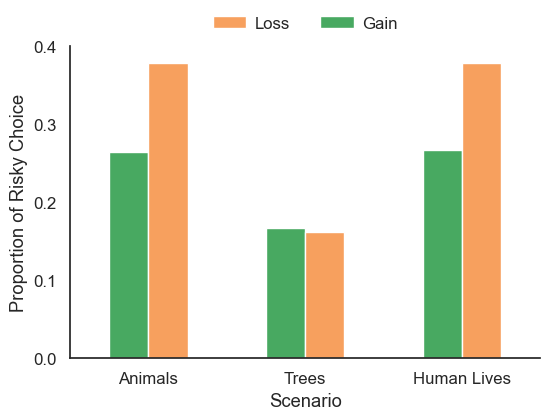

In [299]:
# Proportion Choosing Risky Option
ax = scn_prop_risky.plot(kind="bar", color = [ green, orange])
fig.set_size_inches(.5, .5)

fig = ax.get_figure()
# change labels
#ax.set_title("Proportion Choosing Risky Option by Scenario")
ax.set_xlabel("Scenario")
ax.set_xticklabels(labels = ['Animals', 'Trees', 'Human Lives' ], rotation = 0)
ax.set_ylabel("Proportion of Risky Choice")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0,0.1,.2,.3,.4])
fig.tight_layout(pad=3)

##plt.legend(bbox_to_anchor=(.2,1.01,.5,1), loc="lower center", ncol=3, frameon=False, handletextpad=0.5, mode='expand')
plt.legend(['Gain',"Loss"],bbox_to_anchor=(.5,1), loc="lower center", ncol=3, frameon=False, handletextpad=0.5, mode='expand')
plt.show()


In [290]:
##fig, axes = plt.subplots(1,2, figsize=(8,5),gridspec_kw={'wspace':0.5,'hspace':0.5})
##sns.scatterplot(x = 'NEP_Score', y = 'rating_num', data = loss_condition, ax = axes[0])
##sns.scatterplot(x = 'NEP_Score', y = 'rating_num', data = gain_condition, ax = axes[1])

In [120]:
forest = main_analysis[main_analysis['scenario_clean'] == 'forest'] 
animals = main_analysis[main_analysis['scenario_clean'] == 'forest'] 
humans = main_analysis[main_analysis['scenario_clean'] == 'forest'] 

main_analysis.groupby('scenario_clean')['NEP_Score'].describe()

,count,mean,std,min,25%,50%,75%,max
scenario_clean,,,,,,,,
animals,71.0,15.985915,6.001174,0.0,11.0,16.0,20.0,28.0
forest,67.0,16.149254,6.177314,8.0,11.0,16.0,21.0,30.0
humans,67.0,17.029851,6.210866,8.0,11.0,17.0,21.0,35.0


In [292]:
##### Rating Number Checks 
main_analysis.groupby('scenario_mapped')['rating_num'].mean()


scenario_mapped
animals_gain    3.558824
animals_loss    4.000000
forest_gain     2.972222
forest_loss     3.161290
humans_gain     3.166667
humans_loss     3.810811
Name: rating_num, dtype: float64

##### Manipulation / Attention Tests

In [304]:
#look where rationale answer is not null 
rationale_notnull = main_analysis[~main_analysis['rationale'].isna()]
###rationale_cross = pd.crosstab( rationale_notnull['frame'],rationale_notnull['option_selected'], normalize='index')
rationale_cross = pd.crosstab( rationale_notnull['option_selected'],rationale_notnull['frame'], normalize='columns')

print("Breakdown when Rationale answer is not null")
print(f"""Sample Size: {rationale_notnull.shape[0]}""")
print(f"""Gain Sample Size: {rationale_notnull[rationale_notnull['frame'] == 'gain'].shape[0]}""")
print(f"""Loss Sample Size: {rationale_notnull[rationale_notnull['frame'] == 'loss'].shape[0]}""")
rationale_cross

Breakdown when Rationale answer is not null
Sample Size: 162
Gain Sample Size: 85
Loss Sample Size: 77


frame,gain,loss
option_selected,,
Proposal A,0.788235,0.571429
Proposal B,0.211765,0.428571


In [61]:
##look were ADP is not familar
ADP_cross = pd.crosstab(ADP_notyes['frame'], ADP_notyes['option_selected'], normalize='index')
##ADP_cross = pd.crosstab(main_analysis['frame'], main_analysis['option_selected'], normalize='index')

print("Breakdown when ADP answer is not true")
print(f"""Sample Size: {ADP_notyes.shape[0]}""")
print(f"""Gain Sample Size: {ADP_notyes[ADP_notyes['frame'] == 0].shape[0]}""")
print(f"""Loss Sample Size: {ADP_notyes[ADP_notyes['frame'] == 1].shape[0]}""")

Breakdown when ADP answer is not true
Sample Size: 93
Gain Sample Size: 50
Loss Sample Size: 43


In [106]:
#look where Rating matches answer
rating_appr = main_analysis[((main_analysis['option_selected']=='Proposal A') & (main_analysis['rating_num']<= 4 )) | ((main_analysis['option_selected']=='Proposal B') & (main_analysis['rating_num'] >= 4 ))]
rating_cross = pd.crosstab(rating_appr['frame'], rating_appr['option_selected'])###, normalize='index')
print("Breakdown when Rating matches answer")
print(f"""Sample Size: {rating_appr.shape[0]}""")
print(f"""Gain Sample Size: {rating_appr[rating_appr['frame'] == 0].shape[0]}""")
print(f"""Loss Sample Size: {rating_appr[rating_appr['frame'] == 1].shape[0]}""")
rating_cross

Breakdown when Rating matches answer
Sample Size: 185
Gain Sample Size: 0
Loss Sample Size: 0


option_selected,Proposal A,Proposal B
frame,,
gain,72,21
loss,60,32


##### Plotting & Initial Tests

In [170]:
##set up graph formatting 

blues = sns.color_palette(palette='Blues_d')
oranges = sns.color_palette(palette='Oranges_d')
greens = sns.color_palette(palette='Greens_d')

green = greens[2]
orange = oranges[0]
blue = blues[3]
sns.set(style='white', font_scale=1.1)


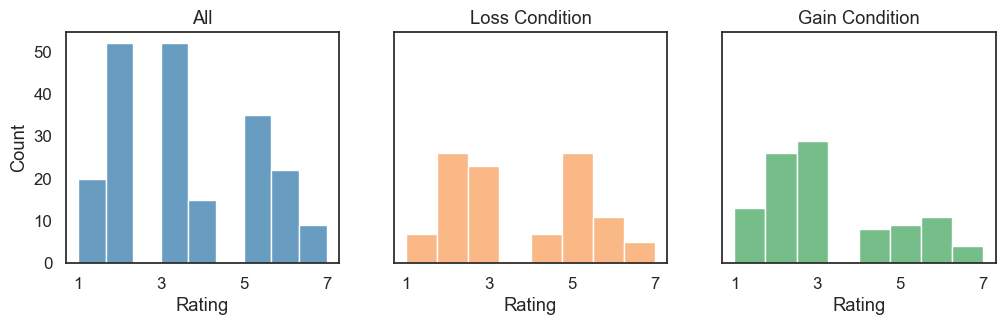

In [171]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

sns.histplot(data=main_analysis, x='rating_num', ax=axes[0], color= blue, edgecolor="w")

#sns.histplot(data=main_analysis, x='rating_num', ax=axes[0], color= 'C0', edgecolor="w")
axes[0].set_title('All')
axes[0].set_xlabel('Rating')
axes[0].set_xticks([1,3,5,7])

sns.histplot(data=loss_condition, x='rating_num', ax=axes[1], color= orange,  edgecolor="w")
axes[1].set_title('Loss Condition')
axes[1].set_xlabel('Rating')
axes[1].set_xticks([1,3,5,7])

sns.histplot(data=gain_condition, x='rating_num', ax=axes[2],  color= green, edgecolor="w")
axes[2].set_title('Gain Condition')
axes[2].set_xlabel('Rating')
axes[2].set_xticks([1,3,5,7])

plt.show()


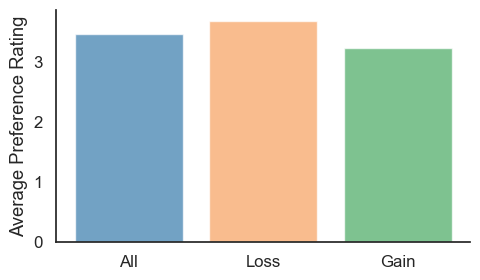

In [168]:
##Plot graph for average rating by condition 
values = np.array([main_analysis.rating_num.mean(), loss_condition.rating_num.mean(), gain_condition.rating_num.mean(), ])
plt.figure(figsize=(5,3))
plt.bar(np.arange(3), values,  color=[ blue, orange, green ], alpha=0.7, capsize=1, ecolor='dimgrey')
sns.despine()
plt.ylabel('Average Preference Rating')
plt.xticks(np.arange(3), [ 'All', 'Loss', 'Gain', ], rotation='horizontal')
plt.tight_layout()
#plt.show()

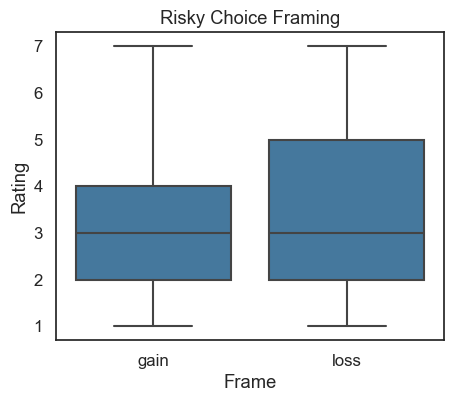

In [169]:
fig = plt.figure(figsize=(5,4))
ax = sns.boxplot(x='frame', y='rating_num', data=main_analysis, color = blue)
plt.title('Risky Choice Framing')
plt.xlabel('Frame')
plt.ylabel('Rating')
plt.show()

In [311]:
print("\nAverage rating by condition & option:")
print(pd.crosstab( index = main_analysis['option_selected'], columns = main_analysis['frame'], values = main_analysis['rating_num'], aggfunc='mean'))

print("\nAverage rating by condition:")
print(main_analysis.groupby('frame').rating_num.mean())


Average rating by condition & option:
frame                gain      loss
option_selected                    
Proposal A       2.623377  2.902778
Proposal B       5.260870  5.393939

Average rating by condition:
frame
gain    3.230000
loss    3.685714
Name: rating_num, dtype: float64


In [312]:
### look where rating matches to answer choice 
print("\nAverage rating by condition & option:")
print(pd.crosstab( index = rating_appr['option_selected'], columns = rating_appr['frame'], values = rating_appr['rating_num'], aggfunc='mean'))

print("\nAverage rating by condition:")
print(rating_appr.groupby('frame').rating_num.mean())


Average rating by condition & option:
frame                gain      loss
option_selected                    
Proposal A       2.388889  2.416667
Proposal B       5.571429  5.468750

Average rating by condition:
frame
gain    3.107527
loss    3.478261
Name: rating_num, dtype: float64


In [78]:
#ttest for experiment 

gain = main_analysis['rating_num'][main_analysis['frame'] == 0]
loss = main_analysis['rating_num'][main_analysis['frame'] == 1]

t_stat, p_value = stats.ttest_ind(gain, loss)

# results
print("T-statistic:", t_stat)
print("P-value:", p_value)



T-statistic: -1.938984731295546
P-value: 0.05388945375619895


In [118]:
dct = {
    'gain': [72 , 21],
    'loss': [ 60,  32 ]
}
df = pd.DataFrame(dct, index=['Prop_A', 'Prop_B'])


table = sm.stats.Table.from_data(rating_appr[['frame', 'option_selected']])
rslt = table.test_nominal_association()
print(table.local_oddsratios)
#print( rslt.pvalue )


option_selected  Proposal A  Proposal B
frame                                  
gain               1.828571         NaN
loss                    NaN         NaN
df          1
pvalue      0.0664493551754538
statistic   3.368620979169025


In [60]:
#function for signficance 
def sig_effect(pvalue):
    if pvalue <= .01:
        return f"""significant at 1% level"""
    elif pvalue <= .05:
        return f"""significant at 5% level"""
    elif pvalue <= .1:
        return f"""significant at 10% level"""
    else:
        return "not significant"


In [119]:
import math as ma 
# Calculate difference between means and pooled standard deviation
diff = gain_condition['rating_num'].mean() - loss_condition['rating_num'].mean()
pooledstdev = ma.sqrt(((gain_condition['rating_num'].std() ** 2 + loss_condition['rating_num'] ** 2) / 2) )

# Calculate Cohen's d
cohend = diff / pooledstdev
print(cohend)

TypeError: cannot convert the series to <class 'float'>

#### Regression & Results

#### Linear Models

In [228]:
#simple linear regression 
lin_reg = sm.OLS.from_formula('rating_num ~ frame', data = main_analysis).fit()
print("frame coeff:", lin_reg.params[1])
print("frame p-vale:", lin_reg.pvalues[1])
print("\nsignficicant effect? --> ", sig_effect(lin_reg.pvalues[1]))

###print("\n\n\n",lin_reg.summary())

frame coeff: 0.45571428571428413
frame p-vale: 0.05388945375619913

signficicant effect? -->  significant at 10% level


In [229]:
lin_reg = sm.OLS.from_formula('rating_num ~ frame', data = ADP_notyes).fit()
print("frame coeff:", lin_reg.params[1])
print("frame p-vale:", lin_reg.pvalues[1])
print("\nsignficicant effect? --> ", sig_effect(lin_reg.pvalues[1]))
###print("\n\n\n",lin_reg.summary())

frame coeff: 0.8034371643394196
frame p-vale: 0.023228201981236936

signficicant effect? -->  significant at 5% level


In [247]:
#with scenario 
reg_scn = sm.OLS.from_formula('rating_num ~ frame + scenario_clean', data = main_analysis).fit()
##reg_dem = sm.OLS.from_formula('rating_num ~ frame + age_num + gender_num + ethnicity_num + education_num', data = main_analysis).fit()
print("frame coeff:", reg_scn.params[1])
print("frame p-vale:", reg_scn.pvalues[1])
print("\nsignficicant effect?", sig_effect(reg_scn.pvalues[1]))
###print("\n\n\n",reg_scn.summary())


frame coeff: -0.7042083132034722
frame p-vale: 0.013938629762746296

signficicant effect? significant at 5% level


In [249]:
#with scenario 
reg_scn = sm.OLS.from_formula('rating_num ~ frame + scenario_clean', data = rating_appr).fit()
##reg_dem = sm.OLS.from_formula('rating_num ~ frame + age_num + gender_num + ethnicity_num + education_num', data = main_analysis).fit()
print("frame coeff:", reg_scn.params[1])
print("frame p-vale:", reg_scn.pvalues[1])
print("\nsignficicant effect?", sig_effect(reg_scn.pvalues[1]))
reg_scn.summary()

frame coeff: -0.8787438870194063
frame p-vale: 0.0026454966235383943

signficicant effect? significant at 1% level


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rating_num   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     4.066
Date:                Sat, 05 Aug 2023   Prob (F-statistic):            0.00796
Time:                        16:20:43   Log-Likelihood:                -346.62
No. Observations:                 185   AIC:                             701.2
Df Residuals:                     181   BIC:                             714.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    3.4925      0.233     15.013      0.000       3.033       3.952
scenario_clean[T.forest]    -0.8787      0.288     -3.048      0.003      -1.448      -0.310
scenario_clean[T.humans]    -0.2561      0.283     -0.906      0.366      -0.814       0.302
frame                        0.3232      0.235      1.377      0.170      -0.140       0.786
==============================================================================
Omnibus:                       15.341   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.866
Skew:                           0.558   Prob(JB):                      0.00161
Kurtosis:                       2.349   Cond. No.                         4.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [232]:
#with basic demographic controls 
reg_dem = sm.OLS.from_formula('rating_num ~ frame + scenario_clean + age_num + gender_num + ethnicity_num + education_num', data = main_analysis).fit()
print("frame coeff:", reg_dem.params[1])
print("frame p-vale:", reg_dem.pvalues[1])
print("\nsignficicant effect?", sig_effect(reg_dem.pvalues[1]))
###print("\n\n\n",reg_dem.summary())

frame coeff: -0.6953018830770973
frame p-vale: 0.01630137985019562

signficicant effect? significant at 5% level


In [233]:
#with addl. demographic controls 
reg_dema = sm.OLS.from_formula('rating_num ~ frame + scenario_clean + age_num + gender_num + ethnicity_num + education_num + contintent_num + student_num', data = main_analysis).fit()
print("frame coeff:", reg_dema.params[1])
print("frame p-vale:", reg_dema.pvalues[1])
print("\nsignficicant effect?", sig_effect(reg_dema.pvalues[1]))
###print("\n\n",reg_dema.summary())

frame coeff: -0.7159684973780202
frame p-vale: 0.014273453210051877

signficicant effect? significant at 5% level


In [235]:
#with ADP num 
reg_ADP = sm.OLS.from_formula('rating_num ~ frame + scenario_clean + age_num + gender_num + ethnicity_num + education_num + contintent_num + student_num + ADP_num', data = main_analysis).fit()
print("frame coeff:", reg_ADP.params[1])
print("frame p-vale:", reg_ADP.pvalues[1])
print("\nsignficicant effect?", sig_effect(reg_ADP.pvalues[1]))
###print("\n\n",reg_ADP.summary())

frame coeff: -0.720259798593593
frame p-vale: 0.013411421578265212

signficicant effect? significant at 5% level


In [237]:
#with nep scoring
reg_NEP = sm.OLS.from_formula('rating_num ~ frame * NEP_Score', data = main_analysis).fit()
print("frame coeff:", reg_NEP.params[1])
print("frame p-vale:", reg_NEP.pvalues[1])
print("\nsignficicant effect?", sig_effect(reg_NEP.pvalues[1]))
###print("\n\n",reg_NEP.summary())

frame coeff: -0.49147972628623543
frame p-vale: 0.46645207576740577

signficicant effect? not significant


In [238]:
reg_nep_interact = sm.OLS.from_formula( 'rating_num ~ frame + NEP_Score + frame: NEP_Score + scenario_clean  + age_num + gender_num + ethnicity_num + education_num', data=main_analysis).fit()
###print(reg_nep_interact.summary())

In [239]:
from statsmodels.iolib.summary2 import summary_col
lin_reg = sm.OLS.from_formula('rating_num ~ frame', data = main_analysis).fit()

reg_dema = sm.OLS.from_formula('rating_num ~ frame + age_num + gender_num + ethnicity_num + education_num + contintent_num + student_num', data = main_analysis).fit()
reg_ADP = sm.OLS.from_formula('rating_num ~ frame + age_num + gender_num + ethnicity_num + education_num + contintent_num + student_num + ADP_num', data = main_analysis).fit()

models = [lin_reg, reg_dema, reg_ADP,  reg_nep_interact ]


summary_table = summary_col(models, 
                            stars=True, 
                            float_format='%0.2f',
                            model_names=['Model w/o Covariates', 'Model w/ Basic Demographics', 'Model w/ All Demographics',  'Model w/ Interaction'],
                            info_dict={'N': lambda x: "{0:d}".format(int(x.nobs)),
                                       'R2': lambda x: "{:.2f}".format(x.rsquared)})

###print(summary_table)

#### Ordinal Regression

In [475]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
import mord 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
main_analysis['frame'] = le.fit_transform(main_analysis['frame']) ##0 = gain; 1 = loss
main_analysis['frame_rev'] = 1 - main_analysis['frame'] ##1 = gain; 0 = loss
main_analysis['scenario_clean_cat'] = le.fit_transform(main_analysis['scenario_clean'])
main_analysis['option_selected_cat'] = le.fit_transform(main_analysis['option_selected']) ##0 = Prop A, 1 = Prop B
main_analysis['option_selected_rev'] = 1 - main_analysis['option_selected_cat']  ## Reversing the encoding

###### Note, main_analysis is where the rating matches the choice selection 


/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_34610/2684769603.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_appr['frame'] = le.fit_transform(rating_appr['frame'])
/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_34610/2684769603.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_appr['frame_rev'] = 1 - rating_appr['frame']
/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_34610/2684769603.py:13: SettingWithCopyWarning: 
A value is trying to be set on a

In [477]:
####ord_logit_na = Logit.from_formula("rating_num ~ 0 + frame_rev + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num ",rating_appr, distr='logit').fit(method='bfgs')

ord_logit_ratapp = OrderedModel.from_formula("rating_num ~ 0 + frame_rev",rating_appr_rat, distr='logit').fit(method='bfgs')
ord_logit_ratapp.summary()

Optimization terminated successfully.
         Current function value: 1.774060
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:             rating_num   Log-Likelihood:                -267.88
Model:                   OrderedModel   AIC:                             549.8
Method:            Maximum Likelihood   BIC:                             570.9
Date:                Sun, 06 Aug 2023                                         
Time:                        19:09:52                                         
No. Observations:                 151                                         
Df Residuals:                     144                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
frame_rev     -0.6694      0.293     -2.282      0.022      -1.244      -0.095
1.0/2.0       -2.3970      0.310     -7.729      0.000      -3.005      -1.789
2.0/3.0        0.4536      0.147      3.088      0.002       0.166       0.742
3.0/4.0       -0.0292      0.154     -0.189      0.850      -0.331       0.273
4.0/5.0       -1.0761      0.292     -3.690      0.000      -1.648      -0.505
5.0/6.0       -0.1478      0.202     -0.731      0.465      -0.544       0.249
6.0/7.0        0.5399      0.241      2.240      0.025       0.068       1.012
==============================================================================
"""

In [468]:
ord_logit_na = OrderedModel.from_formula("rating_num ~ frame_rev + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num ",rating_appr, distr='logit').fit(method='bfgs')
print(ord_logit_na.summary())

PatsyError: Error evaluating factor: NameError: name 'frame_rev' is not defined
    rating_num ~ frame_rev + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num
                 ^^^^^^^^^

In [ ]:
#####Do Not Re-run

In [416]:
ord_logit_na = OrderedModel.from_formula("rating_num ~ 0 + frame_rev + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num ",rating_appr, distr='logit').fit(method='bfgs')
print("\nsignficicant effect?", sig_effect(ord_logit_na.pvalues[0]))

print("\n\n",ord_logit_na.summary())

Optimization terminated successfully.
         Current function value: 1.740037
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32

signficicant effect? not significant


                              OrderedModel Results                             
Dep. Variable:             rating_num   Log-Likelihood:                -321.91
Model:                   OrderedModel   AIC:                             667.8
Method:            Maximum Likelihood   BIC:                             706.5
Date:                Sun, 06 Aug 2023                                         
Time:                        18:48:45                                         
No. Observations:                 185                                         
Df Residuals:                     173                                         
Df Model:                           6                                         
                         coef    std err          z      P>|z|      [0.025  

In [377]:
####Rating Appr. 
ord_logit = OrderedModel.from_formula("rating_num ~ 0 + frame + age_num + gender_num + ethnicity_num + education_num", rating_appr_rat, distr='logit').fit()
print("\nsignficicant effect?", sig_effect(ord_logit.pvalues[0]))

print("\n\n",ord_logit.summary())



signficicant effect? not significant


                              OrderedModel Results                             
Dep. Variable:             rating_num   Log-Likelihood:                -267.93
Model:                   OrderedModel   AIC:                             557.9
Method:            Maximum Likelihood   BIC:                             591.0
Date:                Sun, 06 Aug 2023                                         
Time:                        18:30:22                                         
No. Observations:                 151                                         
Df Residuals:                     140                                         
Df Model:                           5                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
frame             0.1904      0.295      0.646      0.518      -0.387       0.768
ag

/Users/annaking/Library/Python/3.9/lib/python/site-packages/statsmodels/base/optimizer.py:736: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/Users/annaking/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [242]:

###Simple Ordinal Model for rating_num and frame

##ord_logit = OrderedModel.from_formula("rating_num ~ 0 + frame", main_analysis, distr='logit').fit(method='bfgs')
ord_logit = OrderedModel.from_formula("rating_num ~ 0 + frame", main_analysis, distr='logit').fit()

print("frame coeff:", ord_logit_m.params[1])
print("frame p-vale:", ord_logit_m.pvalues[0])
print("\nsignficicant effect?", sig_effect(ord_logit_m.pvalues[0]))
####print("\n\n",ord_logit_m.summary())


ord_logit2 = OrderedModel.from_formula("rating_num ~ 0 + frame", rating_appr,
                                      distr='logit').fit(method='bfgs')

print("frame coeff:", ord_logit2.params[1])
print("frame p-vale:", ord_logit2.pvalues[0])
print("\nsignficicant effect?", sig_effect(ord_logit2.pvalues[0]))
####print("\n\n",ord_logit_m.summary())


ord_logit3 = OrderedModel.from_formula("rating_num ~ 0 + frame", df_nodup_rap,
                                      distr='logit').fit(method='bfgs')

print("frame coeff:", ord_logit3.params[1])
print("frame p-vale:", ord_logit3.pvalues[0])
print("\nsignficicant effect?", sig_effect(ord_logit3.pvalues[0]))
####print("\n\n",ord_logit_m.summary())

##205

Optimization terminated successfully.
         Current function value: 1.784075
         Iterations: 385
         Function evaluations: 570
frame coeff: -2.0024239247423288
frame p-vale: 0.058437479356640384

signficicant effect? significant at 10% level
Optimization terminated successfully.
         Current function value: 1.752100
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
frame coeff: -1.9929498432684551
frame p-vale: 0.15243677894911706

signficicant effect? not significant
Optimization terminated successfully.
         Current function value: 1.752502
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
frame coeff: -1.9658063454080237
frame p-vale: 0.13678029617795787

signficicant effect? not significant


In [246]:
###Ordinal Model for rating_num + Scenario


ord_logit_scn = OrderedModel.from_formula("rating_num ~ 0 + frame + scenario_clean_cat", rating_appr,
                                      distr='logit').fit(method='bfgs')

print("frame coeff:", ord_logit_scn.params[1])
print("frame p-vale:", ord_logit_scn.pvalues[0])
print("\nsignficicant effect?", sig_effect(ord_logit_scn.pvalues[0]))

ord_logit_scn.summary()

Optimization terminated successfully.
         Current function value: 1.750135
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
frame coeff: -0.13398319758731872
frame p-vale: 0.1560528874152587

signficicant effect? not significant


/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_34610/3481343270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_appr['scenario_clean_cat'] = le.fit_transform(rating_appr['scenario_clean'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:             rating_num   Log-Likelihood:                -323.78
Model:                   OrderedModel   AIC:                             663.6
Method:            Maximum Likelihood   BIC:                             689.3
Date:                Sat, 05 Aug 2023                                         
Time:                        16:18:48                                         
No. Observations:                 185                                         
Df Residuals:                     177                                         
Df Model:                           2                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
frame                  0.3723      0.262      1.418      0.156      -0.142       0.887
scenario_clean_cat    -0.1340      0.157     -0.852      0.394      -0.442       0.174
1.0/2.0               -2.1281      0.314     -6.775      0.000      -2.744      -1.512
2.0/3.0                0.5329      0.132      4.037      0.000       0.274       0.792
3.0/4.0                0.1129      0.127      0.887      0.375      -0.136       0.362
4.0/5.0               -0.9438      0.249     -3.790      0.000      -1.432      -0.456
5.0/6.0               -0.1721      0.196     -0.879      0.379      -0.556       0.212
6.0/7.0                0.4335      0.239      1.812      0.070      -0.035       0.902
======================================================================================
"""

In [93]:
###Ordinal Model for rating_num + Scenario
main_analysis['scenario_clean_cat'] = le.fit_transform(main_analysis['scenario_clean'])


ord_logit_scn = OrderedModel.from_formula("rating_num ~ 0 + frame + scenario_clean_cat", main_analysis,
                                      distr='logit').fit(method='bfgs')

print("frame coeff:", ord_logit_scn.params[1])
print("frame p-vale:", ord_logit_scn.pvalues[0])
print("\nsignficicant effect?", sig_effect(ord_logit_scn.pvalues[0]))
###print("\n\n",ord_base_logit.summary())


####Ordinal Model for rating_num + Scenario + demographics
ord_logit_dem = OrderedModel.from_formula("rating_num ~ 0 + frame + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num", main_analysis,
                                      distr='logit').fit(method='bfgs')

print("frame coeff:", ord_logit_dem.params[1])
print("frame p-vale:", ord_logit_dem.pvalues[0])
print("\nsignficicant effect?", sig_effect(ord_logit_dem.pvalues[0]))
###print("\n\n",ord_logit_dem.summary())


####Ordinal Model for rating_num + Scenario + all controls 
ord_logit_all = OrderedModel.from_formula("rating_num ~ 0 + frame + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num + contintent_num + student_num = ADP_num", main_analysis,
                                      distr='logit').fit(method='bfgs')

print("frame coeff:", ord_logit_all.params[1])
print("frame p-vale:", ord_logit_all.pvalues[0])
print("\nsignficicant effect?", sig_effect(ord_logit_all.pvalues[0]))
###print("\n\n",ord_logit_all.summary())

Optimization terminated successfully.
         Current function value: 1.782165
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
frame coeff: -0.13305691714656293
frame p-vale: 0.05787938198984669

signficicant effect? significant at 10% level
Optimization terminated successfully.
         Current function value: 1.771360
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
frame coeff: -0.16742983432970646
frame p-vale: 0.04387491601035088

signficicant effect? significant at 5% level
Optimization terminated successfully.
         Current function value: 1.766164
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
frame coeff: -0.16129371916543725
frame p-vale: 0.05369562362650939

signficicant effect? significant at 10% level


#### Logisitc Regression

In [68]:
import statsmodels.formula.api as smf
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

###### Note, main_analysis is where the rating matches the choice selection 
main_analysis['option_selected_cat'] = le.fit_transform(main_analysis['option_selected']) ##0 = Prop A, 1 = Prop B
main_analysis['option_selected_rev'] = 1 - main_analysis['option_selected_cat']  ## Reversing the encoding
main_analysis['scenario_clean_cat'] = le.fit_transform(main_analysis['scenario_clean'])


/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_34610/1844085746.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ADP_notyes['option_selected_cat'] = le.fit_transform(ADP_notyes['option_selected']) ##0 = Prop A, 1 = Prop B
/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_34610/1844085746.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ADP_notyes['option_selected_rev'] = 1 - ADP_notyes['option_selected_cat']  ## Reversing the encoding


In [ ]:
####### DO NOT RE_RUN THESE!!!!
main_anlysis here was where main_anlaysis = rating number appr. 

In [65]:
#####Simple Logit Regression Model 
logit_reg = smf.logit('option_selected_rev ~ frame', main_analysis).fit()
print("frame coeff:", logit_reg.params[1])
print("frame p-vale:", logit_reg.pvalues[1])
print("\nsignficicant effect? --> ", sig_effect(logit_reg.pvalues[1]))
##logit_reg.summary()

Optimization terminated successfully.
         Current function value: 0.589822
         Iterations 5
frame coeff: -0.6035350218702581
frame p-vale: 0.06807580661270433

signficicant effect? -->  significant at 10% level


In [66]:
###ADP Versions 
logit_ADP = smf.logit('option_selected_rev ~ frame + ADP_num', main_analysis).fit()
print("frame coeff:", logit_ADP.params[1])
print("frame p-vale:", logit_ADP.pvalues[1])
print("\nsignficicant effect? --> ", sig_effect(logit_ADP.pvalues[1]))
##logit_ADP.summary()


##Simple Model with ADP Not Yet Only
logit_reg_noADP = smf.logit('option_selected_rev ~ frame', ADP_notyes).fit()  ##1 = Prop A, 0 = Prop B
print("\Simple Model with No ADP Familarity")
print("frame coeff:", logit_reg_noADP.params[1])
print("frame p-vale:", logit_reg_noADP.pvalues[1])
print("\nsignficicant effect? --> ", sig_effect(logit_reg_noADP.pvalues[1]))

Optimization terminated successfully.
         Current function value: 0.589812
         Iterations 5
frame coeff: -0.6058271602217798
frame p-vale: 0.06877829365346907

signficicant effect? -->  significant at 10% level
Optimization terminated successfully.
         Current function value: 0.547944
         Iterations 6
\Simple Model with No ADP Familarity
frame coeff: -1.315676793905937
frame p-vale: 0.0094995840107473

signficicant effect? -->  significant at 1% level


In [78]:
###Additional Regression Models #####
 
##Logit Regression with Frame + Scenario 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 

logit_scn = smf.logit('option_selected_rev ~ frame + scenario_clean_cat', data = main_analysis).fit() ##option A = 1 
print("frame coeff:", logit_scn.params[1])
print("frame p-vale:", logit_scn.pvalues[1])
print("\nsignficicant effect? --->", sig_effect(logit_scn.pvalues[1]))
#print("\n\n\n",logit_scn.summary())

###Logit Regression with Frame + Scenario + Basic Demographic Controls 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 

logit_reg_dem = smf.logit('option_selected_rev ~ frame + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num', data = main_analysis).fit()
print("frame coeff:", logit_reg_dem.params[1])
print("frame p-vale:", logit_reg_dem.pvalues[1])
print("\nsignficicant effect?", sig_effect(logit_reg_dem.pvalues[1]))
##print("\n\n\n",logit_reg_dem.summary())

##Logit regression with basic demographic controls + scenario + ADP
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 

logit_reg_dem_ADP = smf.logit('option_selected_rev ~ frame + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num + ADP_num', data = main_analysis).fit()
print("frame coeff:", logit_reg_dem_ADP.params[1])
print("frame p-vale:", logit_reg_dem_ADP.pvalues[1])
print("\nsignficicant effect?", sig_effect(logit_reg_dem_ADP.pvalues[1]))
##print("\n\n\n",logit_reg_dem.summary())


##Logit regression with all controls 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 
logit_reg_all = smf.logit('option_selected_rev ~ frame + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num + contintent_num + student_num + ADP_num', data = main_analysis).fit()
print("frame coeff:", logit_reg_all.params[1])
print("frame p-vale:", logit_reg_all.pvalues[1])
print("\nsignficicant effect?", sig_effect(logit_reg_all.pvalues[1]))
##print("\n\n\n",logit_reg_all.summary())

Optimization terminated successfully.
         Current function value: 0.589822
         Iterations 5
frame coeff: -0.6035020103886538
frame p-vale: 0.06809653035336248

signficicant effect? ---> significant at 10% level
Optimization terminated successfully.
         Current function value: 0.584748
         Iterations 5
frame coeff: -0.6119511050878793
frame p-vale: 0.06892025138818002

signficicant effect? significant at 10% level
Optimization terminated successfully.
         Current function value: 0.584748
         Iterations 5
frame coeff: -0.6124552750943252
frame p-vale: 0.07030660688562201

signficicant effect? significant at 10% level
Optimization terminated successfully.
         Current function value: 0.579218
         Iterations 5
frame coeff: -0.5849229474280438
frame p-vale: 0.08685263232869725

signficicant effect? significant at 10% level


##### Tables

In [76]:
def get_summary_stats(model, model_name):
    return {
        'model': model_name,
        'coef': round(model.params[1],4),
        'std_err': round(model.bse[1],4),
        'p_value': round(model.pvalues[1],4),
        'conf_int_low':round(model.conf_int()[0][1],4),
        'conf_int_high': round(model.conf_int()[1][1],4),
        'odds_ratio': round(np.exp(model.params[1]),4),
        'n':model.nobs,
        'significant_effect': 'Yes' if model.pvalues[1] < 0.05 else 'No'
    }

###table for ADP Comparison 
summary_stats_ADP = [get_summary_stats(logit_reg, 'All Participants'), 
                 get_summary_stats(logit_ADP, 'ADP_control'),
                 get_summary_stats(logit_reg_noADP, 'ADP_notyes')]
summary_ADP_df = pd.DataFrame(summary_stats_ADP)
summary_ADP_df.T

,0,1,2
model,All Participants,ADP_control,ADP_notyes
coef,-0.6035,-0.6058,-1.3157
std_err,0.3308,0.3329,0.5073
p_value,0.0681,0.0688,0.0095
conf_int_low,-1.2519,-1.2583,-2.31
conf_int_high,0.0448,0.0466,-0.3214
odds_ratio,0.5469,0.5456,0.2683
n,185,185,87
significant_effect,No,No,Yes


In [80]:
###table for Logit Model Comparison 
summary_stats_logit = [get_summary_stats(logit_reg, 'Frame Only'), 
                 get_summary_stats(logit_scn, '+ Scenario'),
                 get_summary_stats(logit_reg_dem, '+ Demographics'), 
                 get_summary_stats(logit_reg_all, '+ All Controls')]

summary_logit_df = pd.DataFrame(summary_stats_logit)
summary_logit_df.T

,0,1,2,3
model,Frame Only,+ Scenario,+ Demographics,+ All Controls
coef,-0.6035,-0.6035,-0.612,-0.5849
std_err,0.3308,0.3308,0.3364,0.3416
p_value,0.0681,0.0681,0.0689,0.0869
conf_int_low,-1.2519,-1.2519,-1.2713,-1.2545
conf_int_high,0.0448,0.0449,0.0474,0.0846
odds_ratio,0.5469,0.5469,0.5423,0.5571
n,185,185,185,185
significant_effect,No,No,No,No


In [157]:
from statsmodels.iolib.summary2 import summary_col

summary_table = summary_col([logit_reg, logit_reg_noADP], 
                            model_names=['Model1', 'Model2'],
                            stars=True)